# **Trading Strategy: Supervised KNN model**

In [1]:
# library import
import os 
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
import seaborn as sb 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# data fetching import 
import yfinance as yf 

## **Project Development Outline:** 

1) **Collect data**
    - stock ticker and adj close 
    
2) **Model construction**
* Train supervised KNN model to classify green and red days, and make, buy and sell decisions based on any pairwise combination of all three model independent variables (features).
* Features: RSI, Z-score, Stochastic Oscillator
* Models dependant variables (values to be predicted): Next periods market state (green or red day)
* Our Hypothesis: *"Feature extreme values should reflect market outliers and act as reversal points. High positive values should indicate a negative reversal and high negative values shoudl indicate a positive reversal"*
            
3) **Backtest that strategy**
* backtest, creating buy and sell signals from model
    - BUY $\rightarrow$ Today's asset close price is predicted positive  
    - SELL $\rightarrow$ Today's Asset close price is predicted negative 

4) **Model Results and Optimisation**
* Grid search optimisation of model
* Quantify the models performance using metrics / risk measures and compare againist benchamrk. 

## **Data Collection**

In [ ]:
# get stock data 
start_date, end_date = "2009-01-01", "2022-12-31"
ticker = ""
BTCUSD_data = yf.download(ticker, start = start_date, end = end_date, auto_adjust = True)
df_ml = pd.DataFrame(BTCUSD_data).loc[:, ["Close", "High", "Low"]] # loc = all rows and specified columns
df_ml 

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low
Ticker,NFLX,NFLX,NFLX
Date,,,
2009-01-02,4.267143,4.357143,4.200000
2009-01-05,4.562857,4.562857,4.302857
2009-01-06,4.705714,4.750000,4.590000
2009-01-07,4.672857,4.734286,4.571429
2009-01-08,4.735714,4.797143,4.485714
...,...,...,...
2022-12-23,294.959991,298.459991,291.910004
2022-12-27,284.170013,293.570007,282.130005


In [177]:
# calculate returns & drop na's
df_ml['Returns'] = df_ml["Close"].pct_change().dropna() 
df_ml

Price,Close,High,Low,Returns
Ticker,NFLX,NFLX,NFLX,
Date,,,,
2009-01-02,4.267143,4.357143,4.200000,NaN
2009-01-05,4.562857,4.562857,4.302857,0.069300
2009-01-06,4.705714,4.750000,4.590000,0.031309
2009-01-07,4.672857,4.734286,4.571429,-0.006982
2009-01-08,4.735714,4.797143,4.485714,0.013452
...,...,...,...,...
2022-12-23,294.959991,298.459991,291.910004,-0.009370
2022-12-27,284.170013,293.570007,282.130005,-0.036581


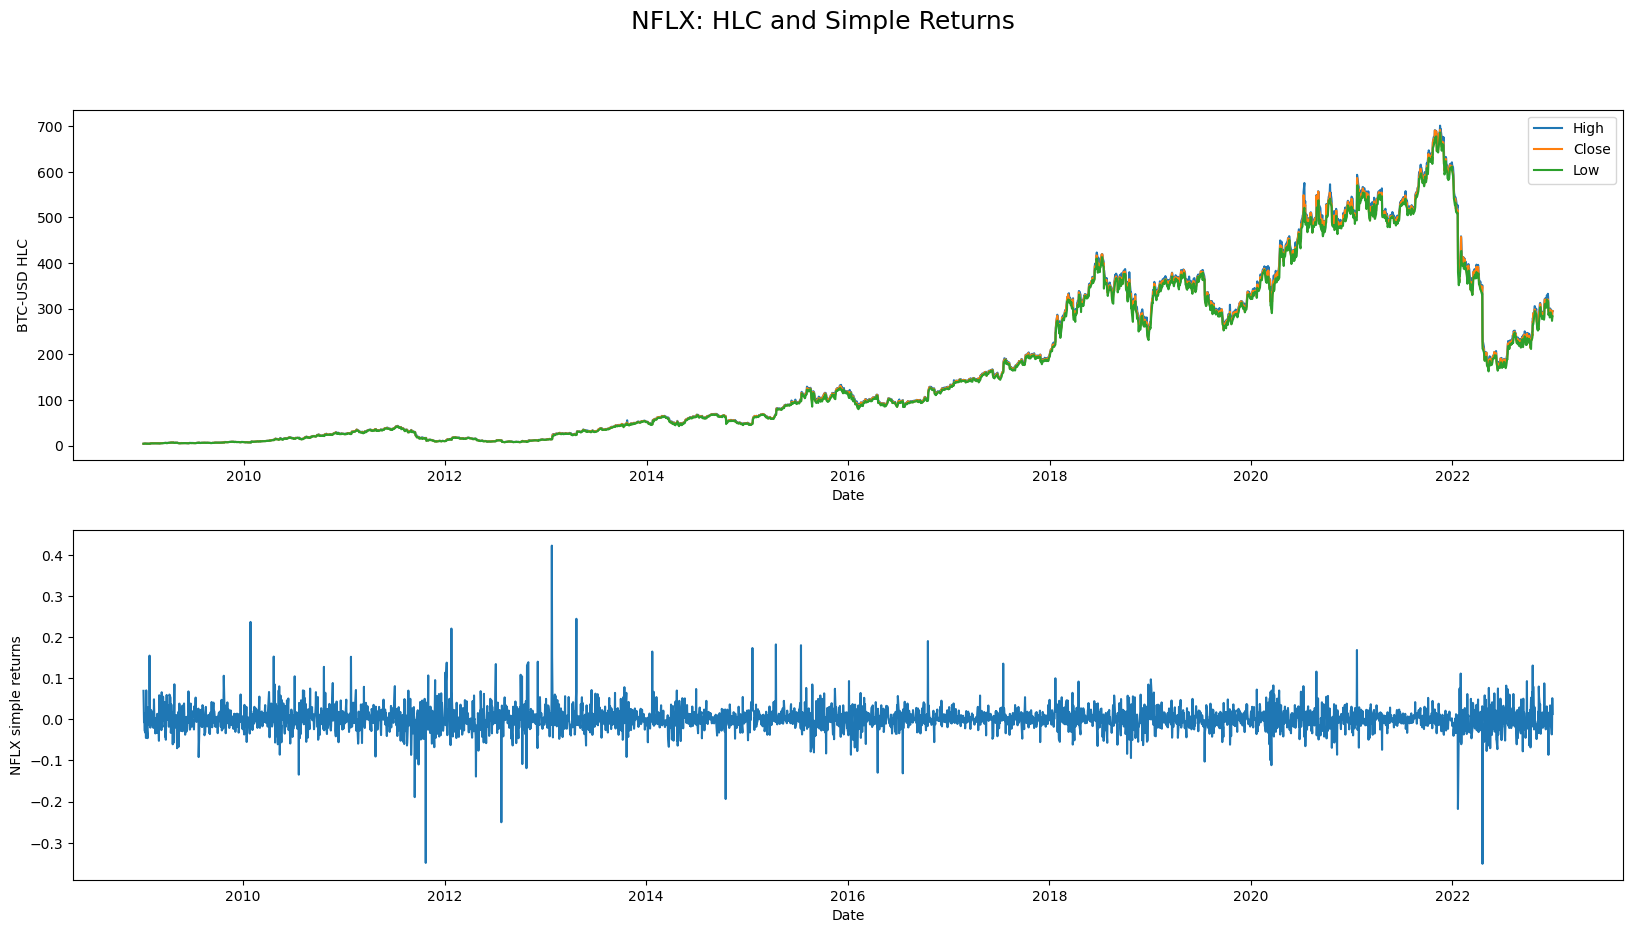

<Figure size 640x480 with 0 Axes>

In [178]:
# vertical stack plots of stock price, high, low and returns 
fig, (ax00, ax01) = plt.subplots(2, figsize = (20, 10))

# Date and time variable, converted from index to column 
date = df_ml.index

# plot 1, price data 
ax00.plot(df_ml['High'], label = "High")
ax00.plot(df_ml['Close'], label = "Close")
ax00.plot(df_ml['Low'], label = "Low")
ax00.set_xlabel("Date")
ax00.set_ylabel("BTC-USD HLC")
ax00.legend()

# plot 2, returns data 
ax01.plot(df_ml["Returns"])
ax01.set_xlabel("Date")
ax01.set_ylabel(f"{ticker} simple returns")

# title 
fig.suptitle(f"{ticker}: HLC and Simple Returns", fontsize = 18)
plt.show()
plt.tight_layout();

## **Feature Constrcution**

In [179]:
# calculate RSI, Z score and add to BTCUSD ML data frame 
# RSI custom function that takes float and int types 
def RSI(returns: float, lookback: int):
    avg_gain = returns.where(returns > 0, 0).abs().rolling(window=lookback).mean()
    avg_loss = returns.where(returns < 0, 0).abs().rolling(window=lookback).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Z-score custom function that takes int and float types 
def ZScore(ma_lookback: int, std_lookback: int, close: float):
    rolling_mean = close.rolling(window=ma_lookback).mean() 
    rolling_std = close.rolling(window=std_lookback).std()
    zscore = (close - rolling_mean) / rolling_std # this is the z score equation 
    return zscore

# Stochastic Indicator that takes float and int types 
def Stoch(data: float, stock_lookback: int, stock_smooth_lookback: int):
    high_max = data["High"].rolling(window=stock_lookback).max()
    low_min = data["Low"].rolling(window=stock_lookback).min()
    k = 100 * ((data["Close"] - low_min) / (high_max - low_min))
    ksmooth = k.rolling(window=stock_smooth_lookback).mean()
    return ksmooth   

In [180]:
# insensate rsi function 
rsi_lkb = 7
df_ml["RSI"] = RSI(df_ml["Returns"], rsi_lkb)

# instantiate z-score function
ma_lkb = 7
std_lkb = 7
df_ml["Z-score"] = ZScore(ma_lkb, std_lkb, df_ml["Close"])

# instantiate stochastic oscillator indicator 
stock_lkb = 14
stock_smooth_lkb = 3
df_ml["Stoch"] = Stoch(df_ml, stock_lkb, stock_smooth_lkb)

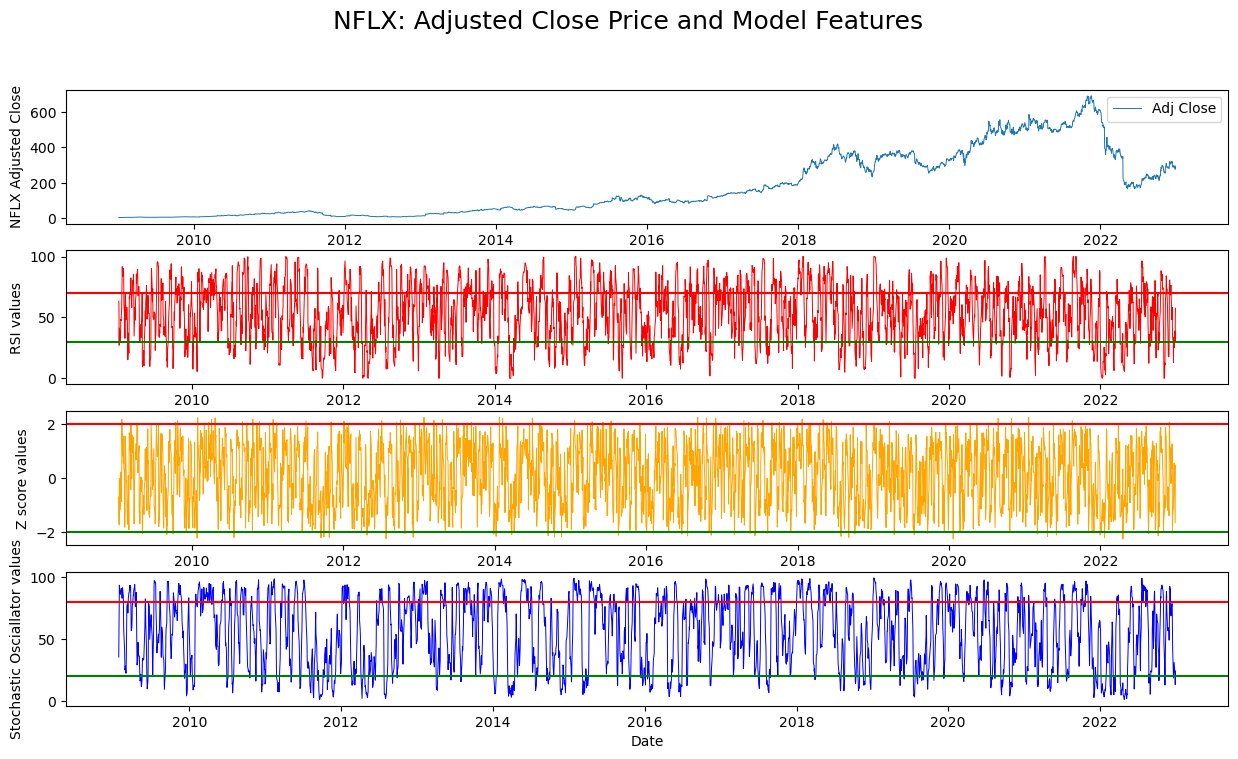

<Figure size 640x480 with 0 Axes>

In [181]:
# plot indicators, first 100 observations only 
# vertical stack plots of stock price, high, low and returns 
fig, (ax00, ax01, ax02, ax03) = plt.subplots(4, figsize=(15, 8))

# plot 1, price data 
ax00.plot(df_ml['Close'], linewidth = 0.7, label = "Adj Close")
ax00.set_xlabel("")
ax00.set_ylabel(f"{ticker} Adjusted Close")
ax00.legend()

# plot 2, returns RSI
ax01.plot(df_ml['RSI'], linewidth = 0.7, c="red")
ax01.axhline(y=70, color="r", linestyle="-")
ax01.axhline(y=30, color="g", linestyle="-")
ax01.set_xlabel("")
ax01.set_ylabel("RSI values")

# plot 3, Z-score 
ax02.plot(df_ml['Z-score'], linewidth = 0.7, c="orange")
ax02.axhline(y=2, color="r", linestyle="-")
ax02.axhline(y=-2, color="g", linestyle="-")
ax02.set_xlabel("")
ax02.set_ylabel("Z score values")

# plot 4, Stochastic 
ax03.plot(df_ml['Stoch'], linewidth = 0.7, c="blue")
ax03.axhline(y=80, color="r", linestyle="-")
ax03.axhline(y=20, color="g", linestyle="-")
ax03.set_xlabel("Date")
ax03.set_ylabel("Stochastic Osciallator values")

# title 
fig.suptitle(f"{ticker}: Adjusted Close Price and Model Features", fontsize=18)
plt.show()
plt.tight_layout()

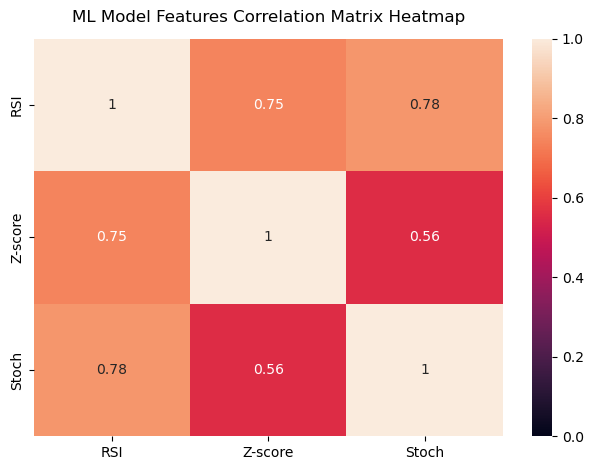

In [191]:
# get correlation of indicators 
feature_labels = ["RSI", "Z-score", "Stoch"]
features = df_ml[feature_labels]
corr_matrix = pd.DataFrame(features.corr().values, columns = feature_labels, index = feature_labels)
heatmap = sb.heatmap(corr_matrix, vmin = 0, vmax = 1, annot = True)
heatmap.set_title("ML Model Features Correlation Matrix Heatmap", fontdict={"fontsize":12}, pad=12)
plt.tight_layout();

In [192]:
# Append the Dependent variable classifier, this is if the days are green or red close days 
def DayClass(returns):
    day_class = []
    for i in returns:
        if i >= 0:
            day_class.append("green")
        else:
            day_class.append("red")
    
    return day_class

In [193]:
df_new = df_ml.dropna()
df_new

Price,Close,High,Low,Returns,RSI,Z-score,Stoch,Day Class
Ticker,NFLX,NFLX,NFLX,,,,,
Date,,,,,,,,
2009-01-26,4.307143,4.457143,4.158571,-0.009527,56.667215,-0.871040,35.347131,red
2009-01-27,4.974286,5.050000,4.702857,0.154892,70.314532,2.179751,51.685956,green
2009-01-28,5.165714,5.174286,4.987143,0.038483,76.893317,1.697721,73.222725,green
2009-01-29,5.268571,5.414286,5.037143,0.019912,91.652381,1.356020,93.314081,green
2009-01-30,5.162857,5.252857,5.045714,-0.020065,83.676260,0.829970,89.570304,red
...,...,...,...,...,...,...,...,...
2022-12-23,294.959991,298.459991,291.910004,-0.009370,24.961317,0.555813,30.976682,red
2022-12-27,284.170013,293.570007,282.130005,-0.036581,38.703107,-1.426916,22.121627,red


In [194]:
# instentiate new data frame with new values column 
day_class = DayClass(df_ml['Returns']) 
df_ml['Day Class'] = day_class
df_ml.dropna(inplace=True)
df_ml

Price,Close,High,Low,Returns,RSI,Z-score,Stoch,Day Class
Ticker,NFLX,NFLX,NFLX,,,,,
Date,,,,,,,,
2009-01-26,4.307143,4.457143,4.158571,-0.009527,56.667215,-0.871040,35.347131,red
2009-01-27,4.974286,5.050000,4.702857,0.154892,70.314532,2.179751,51.685956,green
2009-01-28,5.165714,5.174286,4.987143,0.038483,76.893317,1.697721,73.222725,green
2009-01-29,5.268571,5.414286,5.037143,0.019912,91.652381,1.356020,93.314081,green
2009-01-30,5.162857,5.252857,5.045714,-0.020065,83.676260,0.829970,89.570304,red
...,...,...,...,...,...,...,...,...
2022-12-23,294.959991,298.459991,291.910004,-0.009370,24.961317,0.555813,30.976682,red
2022-12-27,284.170013,293.570007,282.130005,-0.036581,38.703107,-1.426916,22.121627,red


## **Idea Deprecated**:

the ML model is designed to predict today's current state given the feature values of lag days ago. To determine the optimal lag we shift features $k$ lag's in the future and calculaute the series self correlation.  

To find the optimal lag plot the ACF of the features, the lag that gives the largest positive correlation should be chosen for each feature, the intuition is that if there is strong positive correlation with feature vales $t-k$ lags ago and feature values at time $t$, then their will be a continuation in that trend $k$ periods in the future. We are effectivley using values $k$ periods ago to predict the market state today.

We can form buy and sell decisions in the following manner
- Positive Outlier: Wait for first down move - Short $k$ periods in the future
- Negative Move: Wait for first up move - Long $k$ periods in the future 
- close positions based on close condition

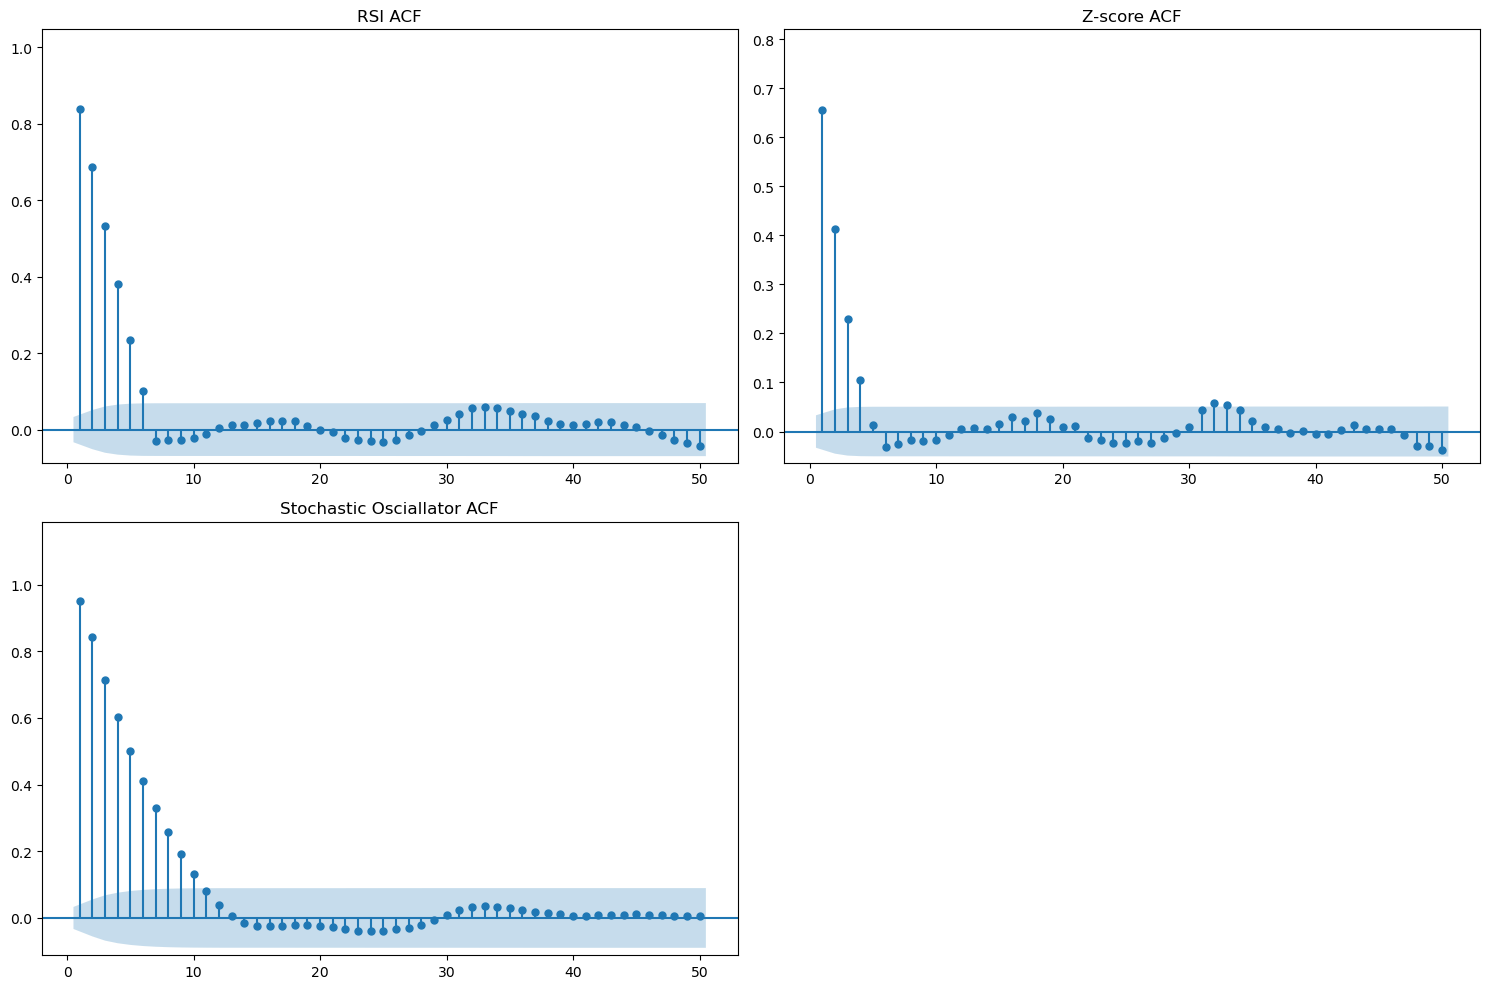

In [195]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 10))

lag = 50
plot_acf(df_ml["RSI"], lags = lag, title = "RSI ACF", auto_ylims=True, zero = False, ax = ax[0, 0])
plot_acf(df_ml["Z-score"], lags = lag, title = "Z-score ACF", auto_ylims=True, zero = False,  ax=ax[0, 1])
plot_acf(df_ml["Stoch"], lags = lag, title = "Stochastic Osciallator ACF", auto_ylims=True, zero = False, ax = ax[1, 0])
ax[1, 1].set_visible(False)
fig.tight_layout()

# array of the lags 
rsi_acf_array = sm.graphics.tsa.acf(df_ml["RSI"], nlags = lag)[1:]
zscore_acf_array = sm.graphics.tsa.acf(df_ml["Z-score"], nlags = lag)[1:]
stoch_acf_array = sm.graphics.tsa.acf(df_ml["Stoch"], nlags = lag)[1:]

In [196]:
# function that gets optimal acf lags 
def OptLag(acfs):
    return np.where(acfs == acfs.max())[0] + 1 # because 0 indexed 

# get optimal lag for each feature 
rsi_lag = OptLag(rsi_acf_array)
zscore_lag = OptLag(zscore_acf_array)
stoch_lag = OptLag(stoch_acf_array)
print(f"Optimal lag RSI: {rsi_lag} \nOptimal lag Z-score: {zscore_lag} \nOptimal lag Stochastic: {stoch_lag}")

Optimal lag RSI: [1] 
Optimal lag Z-score: [1] 
Optimal lag Stochastic: [1]


shift series by optimal lag

In [197]:
df_ml[["RSI"]] = df_ml[["RSI"]].shift(rsi_lag)
df_ml[["Z-score"]] = df_ml[["Z-score"]].shift(zscore_lag)
df_ml[["Stoch"]] = df_ml[["Stoch"]].shift(stoch_lag)

# clear na rows
df_ml.dropna(inplace = True)

## **Trading Signals**

Our reversal values

In [236]:
# for RSI 
threshold_RSI_h = 70
threshold_RSI_l = 30

# for Z score 
threshold_Z_score_h = 1.5
threshold_Z_score_l = -1.5

# for Stochastic
threshold_Stoch_h = 80
threshold_Stoch_l = 20

In [260]:
# features
features = df_ml[feature_labels]
# class label
y = np.where(df_ml["Day Class"] == "green", 1, 0) # change variable from categorical to discrete 

# new data sets where data is split into training and testing data sets 
train_size = 0.7
x_train, x_test, y_train, y_test =  train_test_split(features, y, test_size = 1-train_size, shuffle = False)
train_index = df_ml.index[:len(x_train)]
test_index = df_ml.index[len(x_train):]
# check dimensions
print(x_train.shape)
print(x_test.shape)

(2455, 3)
(1053, 3)


outlier features 

In [ ]:
def TwoOutliers(indicator: pd.DataFrame, low, high):
    return indicator[(indicator <= low) | (indicator >= high)]

RSI_outliers = TwoOutliers(x_train['RSI'], threshold_RSI_l, threshold_RSI_h) # use bitwise (not logical) operator
Z_score_outliers = TwoOutliers(x_train['Z-score'], threshold_Z_score_l, threshold_Z_score_h)
Stoch_outliers = TwoOutliers(x_train['Stoch'], threshold_Stoch_l, threshold_Stoch_h)

In [276]:
feature_outliers = pd.concat([RSI_outliers, Z_score_outliers, Stoch_outliers], join = 'inner', axis = 1)
outlier_days = df_ml['Day Class'][feature_outliers.index]
feature_outliers['Day Class'] = outlier_days # same day all indicators print outliers 
feature_outliers


,RSI,Z-score,Stoch,Day Class
Date,,,,
2009-02-06,79.625442,1.562171,89.912055,red
2009-03-19,70.536839,1.502002,87.836552,red
2009-03-24,77.320959,1.517712,93.090043,green
2009-04-13,84.603987,2.036826,89.461679,green
2009-04-14,89.519893,1.881114,93.856639,red
...,...,...,...,...
2018-07-31,16.778334,-2.162331,13.695215,green
2018-08-17,5.223069,-1.534917,13.346094,red
2018-09-27,84.048305,1.878252,82.748142,green


Get day state one day after reversal signal 

In [306]:
next_dates = []
for indx, date_trg in enumerate(feature_outliers.index):
    for date in x_train.index:
        if date == date_trg:
            next_dates.append(x_train.index[indx+1])
        else:
            pass

get day state and features for next days 

In [312]:
features_outlier_next_days = df_ml['Day Class'][next_dates]

Text(0, 0.5, 'Z score')

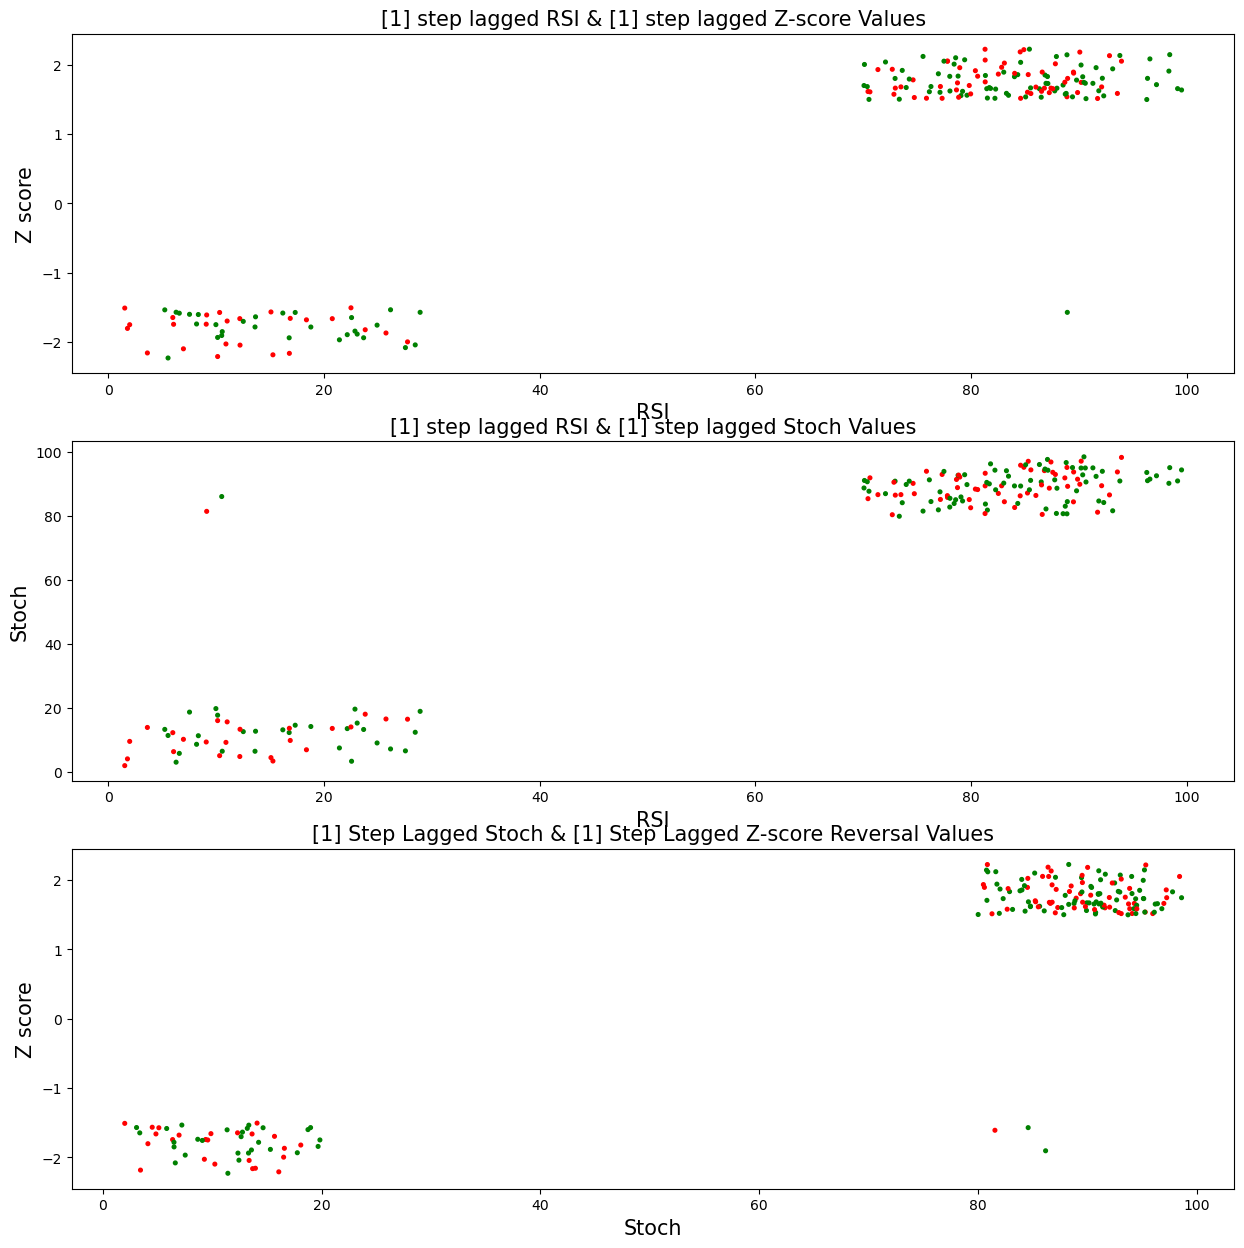

In [ ]:
# visualise data before creating model, does hypothesis hold ?
# visualise different combinations of indicators, as model has only two features
# select the model that categorises day green / red days best 

fig, (ax00, ax10, ax01) = plt.subplots(3, figsize=(15, 15))

# RSI & Z-score 
ax00.scatter(feature_outliers['RSI'], feature_outliers['Z-score'], color = outlier_days, s = 7)
ax00.set_title(f"{rsi_lag} step lagged RSI & {zscore_lag} step lagged Z-score Values", fontsize = 15)
ax00.set_xlabel("RSI", fontsize = 15)
ax00.set_ylabel("Z score", fontsize = 15)

# RSI & Stoch 
ax10.scatter(feature_outliers['RSI'], feature_outliers['Stoch'], color = outlier_days, s = 7)
ax10.set_title(f"{rsi_lag} step lagged RSI & {stoch_lag} step lagged Stoch Values", fontsize = 15)
ax10.set_xlabel("RSI", fontsize = 15)
ax10.set_ylabel("Stoch", fontsize = 15)

# Z-score & Stoch 
ax01.scatter(feature_outliers['Stoch'], feature_outliers['Z-score'], color = outlier_days, s = 7)
ax01.set_title(f"{stoch_lag} Step Lagged Stoch & {zscore_lag} Step Lagged Z-score Reversal Values", fontsize = 15)
ax01.set_xlabel("Stoch", fontsize = 15)
ax01.set_ylabel("Z score", fontsize = 15)

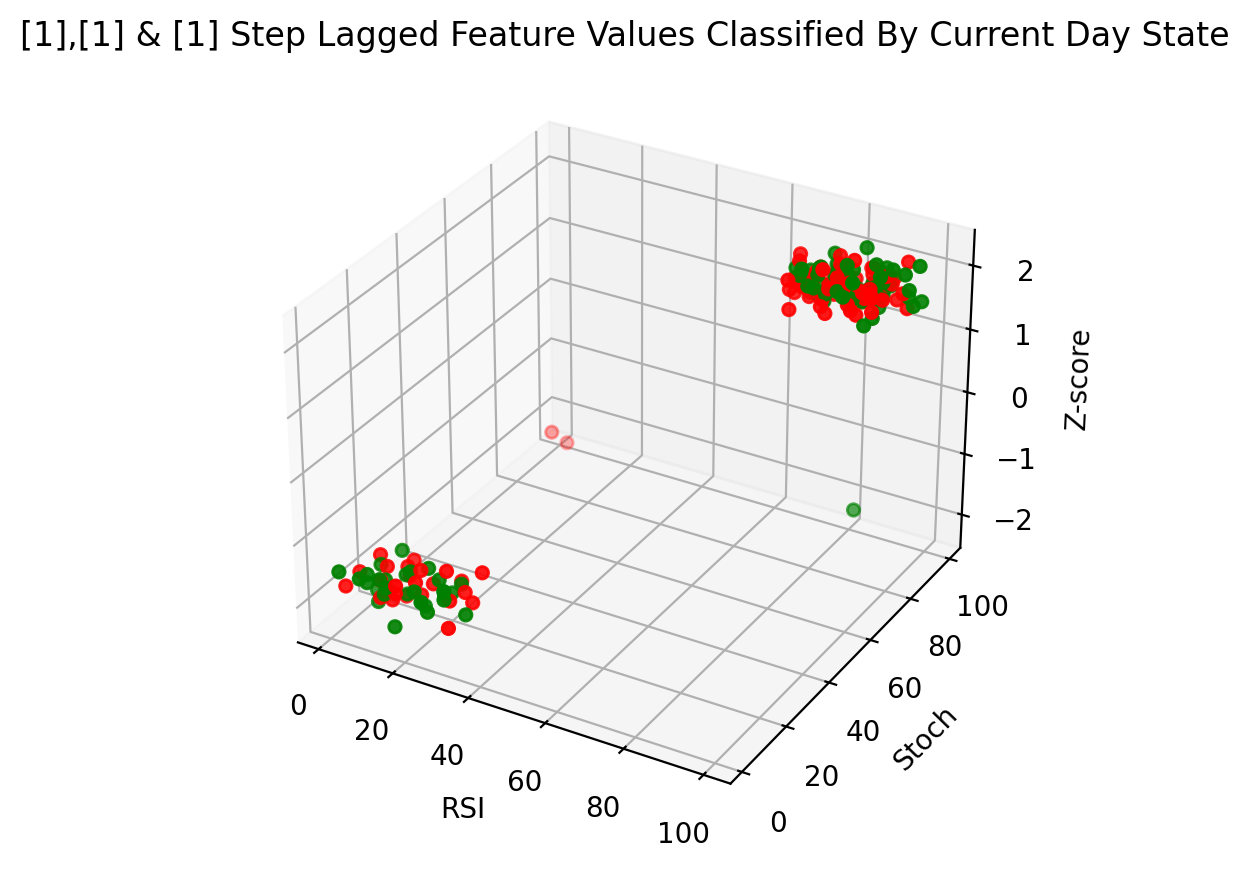

<Figure size 640x480 with 0 Axes>

In [315]:
# Declare and assign axis values 
x = feature_outliers['RSI']
y = feature_outliers['Stoch']
z = feature_outliers['Z-score']

# Create a 3D scatter plot
fig = plt.figure(figsize=(20, 5), dpi = 200)
ax = fig.add_subplot(111, projection='3d')
# Plot the data
ax.scatter3D(x, y, z, c=outlier_days)
# Set labels
ax.set_xlabel('RSI')
ax.set_ylabel('Stoch')
ax.set_zlabel('Z-score')
# Set title
ax.set_title(f'{rsi_lag},{zscore_lag} & {stoch_lag} Step Lagged Feature Values Classified By Current Day State')
# Show the plot
plt.show()
plt.tight_layout();

In [280]:
# fit the knn model
# creating the KNN classifier, declare object knn which is an instanced class
knn = KNeighborsClassifier(n_neighbors=3)
# fit the classifier to the data (out of sample features)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [282]:
# test the knn model, will predict the dependent variable (day class)
state_predictions = knn.predict(x_test)
# evaluate model 
knn.score(x_test, y_test)

0.5454545454545454

[ 1  2  3  4  5  6  7  8  9 10] 
 [0.5, 0.45454545454545453, 0.5454545454545454, 0.4318181818181818, 0.5454545454545454, 0.5, 0.5227272727272727, 0.5227272727272727, 0.5, 0.5227272727272727]


Text(0.5, 1.0, 'KNN SML Model Accuracy Score for Varying Number of Neighbors')

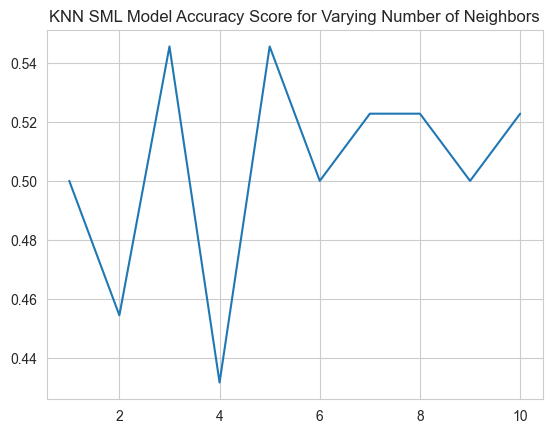

In [283]:
# optimize model by fitting / predicting knn models with different lags 
neighbors = np.arange(1, 11)
test_accuracies = []

# find optimal neighbors
for neighbor in neighbors:
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor)
	#Fit the model
	knn.fit(x_train, y_train)
	# Compute accuracy
	test_accuracies.append(knn.score(x_test, y_test))
print(neighbors, '\n', test_accuracies)
plt.plot(neighbors, test_accuracies)
plt.title("KNN SML Model Accuracy Score for Varying Number of Neighbors")

**IV) Backtest the Strategy**

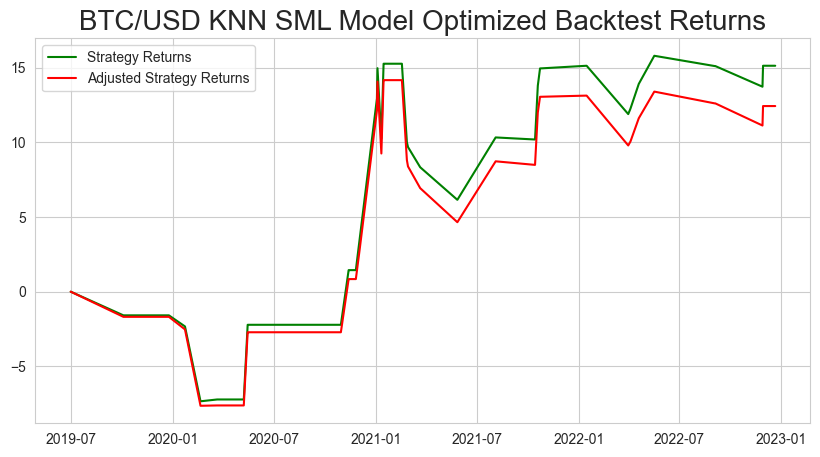

In [287]:
# backtest 
# the prediction trading signal
# note splits are exclusive, half open intervals splits insure no data loss
x_test["Signals (Long Only)"] = state_predictions
x_test["Returns"] = df_ml_new[100:][["Returns"]]

# strategy cumulative returns
x_test['Strategy returns'] = x_test['Signals (Long Only)'] * x_test['Returns']
Cumulative_Strategy_returns = x_test['Strategy returns'].cumsum()*100

# add commission adjusted returns 
x_test["Strategy returns (Commission adjusted)"] = x_test['Signals (Long Only)'] * (x_test['Returns'] - 0.001)
Cumulative_Strategy_returns_commission_adjusted = x_test['Strategy returns (Commission adjusted)'].cumsum()*100

# plotting strategy results 
plt.figure(figsize=(10,5))
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.plot(Cumulative_Strategy_returns_commission_adjusted, color='red', label = 'Adjusted Strategy Returns')
plt.title("BTC/USD KNN SML Model Optimized Backtest Returns", fontsize=20)
plt.legend()
plt.show()